# Curso BancoEstado-CMM: Aprendizaje de Máquinas Avanzado 
**Autores:** Taco de Wolff y Felipe Tobar  

**Fecha:** 15 noviembre, 2019


# Módulo 6 - Modelos para predecir Ventas y Costos
**Contenidos**
- Cargar los datos con Pandas
- Visualizar y interpretar los datos
- Limpiar los datos: eliminar columnas, filas, reemplazar celdas con NaN o vacias
- Separar columnas para la entrada y salida, separar filas para entrenar y testear
- Entrenar varios modelos: red neuronal con PyTorch, RandomForest, ...

## Introducción

Vamos ocupar varias librerías: PyTorch, Pandas, scikit-learn y otras.

Para instalar `missingno` corremos `pip install missingno`.

In [89]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import missingno

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

## Cargar los datos
Los datos en formato CSV son los más rapido para cargar, el formato XLSX de Excel is más sofisticato pero cuesta más en cargar. Usamos `low_memory=False` para evitar una advertencia de Pandas para que no comprima mientras cargando.

Vemos que tenemos `36162` filas y `143` columnas para que necesitemos `40MB`.

In [90]:
df0 = pd.read_csv('ventas_costos.csv', low_memory=False)
df0.info()
df0.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36163 entries, 0 to 36162
Columns: 143 entries, Id to SCP_MIC_PRD_COS_MPM
dtypes: float64(76), int64(45), object(22)
memory usage: 39.5+ MB


,Id,Periodo,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT,sexo,edad,est_civil,comuna,region,act_eco_cod,act_eco_des,sec_cod,DDVI,DM,DDVE,DDC,DDVI1,DM1,DDVE1,DDC1,DDVI2,DM2,DDVE2,DDC2,DDVI3,DM3,DDVE3,DDC3,DDVI4,DM4,DDVE4,DDC4,DDVI5,DM5,DDVE5,DDC5,DDVI6,DM6,DDVE6,DDC6,VFM_M6,dda_max,Vector_FM_Max,Vector_FM_Min,MPMA,MPMR,DPMA,DPMR,NPB30,MPB30,NPE3090,MPE3090,NPS90,MPS90,NA6M,MA6M,pro_sin_acl,inf_lab,Tipo_Cliente,dop_sdo_cst,Nuevo_Antiguo_Prod,Comportamiento_SBFI,Comportamiento_BEME,Perfil_Riesgo,mora_6m,var_deu,Score_Amb_SMRT01,Ptje_Amb_SMRT01,Cant_Op_12M_SICA,Ptje_SICA,PERFIL,COD_OFI,OFICINA,REGION_OFICINA,MODULO,ZONA_OFICINA,COD_EJEC_ORIGEN,TIPO_CLIENTE,CHEQ,Protestos_Sin_Aclarar,Infracciones_Laborales,COD_EJC_ACTUAL,Medidas_Restrictivas,CHEQ_SIN_CV,CHEQ_CV,CTA_CTE,FONDOS_MUTUOS,AHORRO,DEP_PLAZO,TCDN,TCDI,FRECUENCIA_INGRESO,CLIENTE_FORMAL,COD_EJECUTIVO,COMUNA_EXPERIAN,CANT_COMPRAS_MENSUALES,FORMALIDAD,MONTO_PROM_COMPRA,OTRAS_DEUDAS,OTROS_GASTOS_ME,TOTAL_ACT_CIRC,TOTAL_ACT_FIJO,CUADRANTE,SUB_SEGMENTO,MICRO_SEGMENTO,SCP_MSL_COD_SUC,SCP_MSL_TIP_CRD_SOL,SCP_MSL_TIP_MDU,SCP_MTT_TIT_COM,SCP_MTT_TIT_EDA,SCP_MTT_TIT_EST_CIV,SCP_MTT_TIT_NAC,SCP_MTT_TIT_RGM_CYG,SCP_MTT_TIT_RGN,SCP_MTT_TIT_SEX,SCP_MTT_TIT_TSC_CMR,SCP_MTT_FEC_NCT_CLI,SCP_MIC_PFL_PMA_NEG,SCP_MIC_FOR,SCP_MIC_NNS,SCP_MIC_SGM,SCP_MIC_SSG,SCP_MIC_MCS,SCP_MIC_DEU_PRO_VIV,SCP_MIC_CNE_INA,SCP_MIC_FEC_INA,SCP_MIC_ATE,SCP_MCE_FEC_ULT_CRD,SCP_MCE_LCR_DIS,SCP_MPD_MNT_SOL,SCP_MBU_SBS_HBT_ASG,SCP_MIC_GRP_FAM_ADL,SCP_MIC_GRP_FAM_NNO,SCP_MIC_GST_FAM_SME,SCP_MIC_OTR_GST_VIV,SCP_MIC_PRD_COS_MOB,SCP_MIC_PRD_COS_MPM
0,1,201601,1078167,85000,38500,600000,191800,319667,439667,0,0.0,83.0,0.0,50.0,5.0,0.0,S/I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no deudor,0.0,NUEVO,BUENO,BUENO,BUENO,0.0,1.0,0.078022,921.97797,0.0,934.268799,MI,331.0,Stgo. Independencia,13.0,Metrop. Norte,Zona Metropolitana,NaN,deudor comercial,X,0.0,0.0,6062.0,NO,31.0,NaN,NaN,NaN,82531.0,NaN,NaN,NaN,M,0,6817,81,4,SF,150000,0,0,550000,30200000,NaN,106,1943,331,101,5,81,80,4,1,9,13,M,1,1935-12-29,600,SF,9088,MMIC,106,1943,6,0,9999-12-31,686,2006-05-23,0,1200000,0,2,1,200000,0,0.000000e+00,1.000000e+33
1,2,201601,1917765,190000,79332,1446666,277060,461767,391767,0,0.0,78.0,3.0,NaN,0.0,62111.0,"Botillerías: Depósitos de vinos, licores y beb...",3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no deudor,0.0,NUEVO,BUENO,BUENO,BUENO,0.0,1.0,0.078022,921.97797,0.0,934.268799,MI,357.0,Stgo. El Bosque,13.0,Metrop. Sur,Zona Metropolitana,NaN,deudor comercial,X,0.0,0.0,6318.0,NO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,1,6698,100,8,FO,175000,0,0,4000000,56000000,NaN,106,7021,357,101,6,100,76,4,1,9,13,F,1,1939-12-29,240,FO,9023,MMIC,106,7021,6,1,1996-05-29,544,2013-09-25,0,3000000,0,1,0,120000,0,0.000000e+00,1.000000e+38
2,3,201601,2650972,107927,385000,1423333,271055,451759,842639,0,2.0,75.0,1.0,80.0,13.0,62522.0,Artículos típicos (artesanía),3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NUEVO,BUENO,BUENO,BUENO,0.0,1.0,0.078022,921.97797,NaN,NaN,MI,57.0,Santiago Santa Lucia,13.0,Metrop. Centro,Zona Metropolitana,NaN,deudor comercial,NaN,0.0,0.0,6179.0,NO,NaN,NaN,NaN,NaN,301775.0,NaN,NaN,NaN,M,1,7365,80,4,FO,350000,0,0,10800000,40200000,NaN,106,7021,57,100,21,80,74,2,1,1,13,M,1,1941-01-27,264,FO,9025,PERSO,106,7021,6,1,1993-01-01,544,9999-12-31,0,1000000,0,2,0,300000,0,0.000000e+00,1.400000e+38
3,4,201601,3926041,0,578000,2100000,638155,638155,1248041,0,1.0,75.0,2.0,70.0,5.0,62412.0,Prendas de vestir (excepto calzado),3.0

En las primeras diez filas podemos inspectar nuestros datos y sus distintas columnas. Por ejemplo:
- La primera columna `Id` no es tan interesante
- Las columnas `Ventas_IT`, `Costos_Fijos_IT`, y `Costos_Variables_IT` son las que tenemos que predecir probablemente
- Las columnas `sexo`, `edad`, y `est_civil` son datos personales
- La columna `comuna` tiene valores de `NaN`
- La columna `act_eco_des` es texto largo y probablemente dificil usar en entrenamiento
- Entre `MPMA` y `MA6M` hay muchos ceros
- `Tipo_Cliente`, `Nuevo_Antiguo_Prod`, y otras no tienes números sino tiene categorías

Primero vamos a borrar columnas que son sin util. Entonces, sacamos los datos personales y las columnas `Id` y `Periodo` que no contienen información util. También vemos que `ZONA_OFICINA` tiene clasificaciones más general que `MODULO`, en cuyo caso es más eficiente usar solo `MODULO`. Además, `TIPO_CLIENTE` es muy parecido a `Tipo_Client`, entonces borramos `ZONA_OFICINA` y `Tipo_Cliente`.

In [91]:
df1 = df0.copy()
for col in ['Id', 'Periodo', 'sexo', 'edad', 'est_civil', 'ZONA_OFICINA', 'Tipo_Cliente', 'comuna']:
    if col in df1.columns:
        del df1[col]

## Tipos de datos
Con `dtypes` vemos que tipos de datos tenemos en cada columna. Un `int64` significa un número entero, un `float64` es un número con decimales, y un `object` es en nuestro caso texto.

In [92]:
df1.dtypes

Ventas_IT                       int64
Otros_Ingresos_IT               int64
Costos_Fijos_IT                 int64
Costos_Variables_IT             int64
Capacidad_Pago_Ajustada_IT      int64
Capacidad_Pago_IT               int64
Resultado_Operacional_IT        int64
Deudas_IT                       int64
region                        float64
act_eco_cod                   float64
act_eco_des                    object
sec_cod                       float64
DDVI                          float64
DM                            float64
DDVE                          float64
DDC                           float64
DDVI1                         float64
DM1                           float64
DDVE1                         float64
DDC1                          float64
DDVI2                         float64
DM2                           float64
DDVE2                         float64
DDC2                          float64
DDVI3                         float64
DM3                           float64
DDVE3       

Texto también puede ser datos de tiempo en cuyo caso cambiamos `dtype` a `np.datetime`. En nuestro caso, tenemos las columnas `SCP_MTT_FEC_NCT_CLI`, `SCP_MIC_FEC_INA`, `SCP_MCE_FEC_ULT_CRD` que contienen datos de tiempo. Esas columnas tienes valores como `9999-12-31` con son básicamente `nan` en que no tiene ningun valor util. Como Pandas no es capaz de convertir `9999-12-31` a un `datetime`, reemplazámosles a `1900-01-01`. Convertamos las así:

In [93]:
df2 = df1.copy()
for col in ['SCP_MTT_FEC_NCT_CLI', 'SCP_MIC_FEC_INA', 'SCP_MCE_FEC_ULT_CRD']:
    df2.loc[df2[col] == '9999-12-31',col] = '1900-01-01'
    df2[col] = pd.to_datetime(df2[col])
    df2[col] = (df2[col]-pd.to_datetime('1900-01-01')).dt.total_seconds()

## Visualizar y borrar datos faltantes
Con `missingno` podemos visualizar que columnas son vacias o casi vacias. Vemos que has algunas columnas que contiene muchos valores faltantes (parecen blancos). Por ejemplo, la columna `COD_EJEC_ORIGEN` es completamente vacia y podemos borrar.

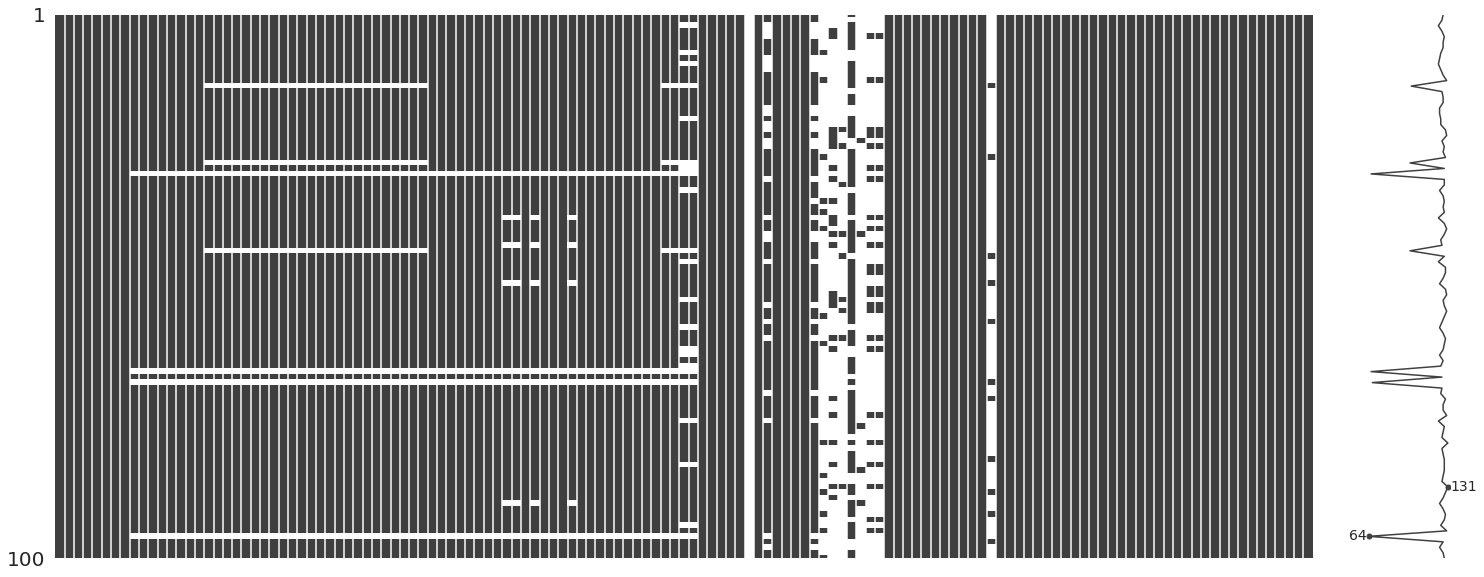

In [94]:
missingno.matrix(df2[:100]);

Vemos que las columnas `COD_EJEC_ORIGEN`, `DEP_PLAZO`, `CUADRANTE` contienen pocos valores. También tenemos varias columnas con montos en cuentas (ahorro, cheque, ...) con valores de `nan` cuando un cliente no tiene esa cuento. Podemos reemplazar esos valores con ceros con `fillna`.

Otras columnas que contienen muchos valores de `nan` son: `comuna`, `Cant_Op_12M_SICA`, `Ptje_SICA`, `CHEQ` (veamos después), `NPB30`, `MPB30`, `MPE3090`, `MA6M`.

 - `MPB30`, `MPE3090`, y `MA6M` son montos que reemplazamos con `0` cuando hay `nan`
 - `NPB30` son los números de protestos ocurridos antes de los 30 días anteriores al pivote, ponemos `0` también
 - Comuna es la comuna donde vive el cliente, ponemos `999` para cada `nan`
 - `Cant_Op_12M_SICA` y `Ptje_SICA` son puntajes en que vamos a reemplazar los `nan` a los promedios de valores que tienen las columnas

In [95]:
cantop12m_promedio = df2['Cant_Op_12M_SICA'].mean()
ptje_promedio = df2['Ptje_SICA'].mean()

print('Cant_Op_12M_SICA promedio:', cantop12m_promedio)
print('Ptje_SICA promedio:', ptje_promedio)

Cant_Op_12M_SICA promedio: 0.22661300158555922
Ptje_SICA promedio: 919.2523772216127


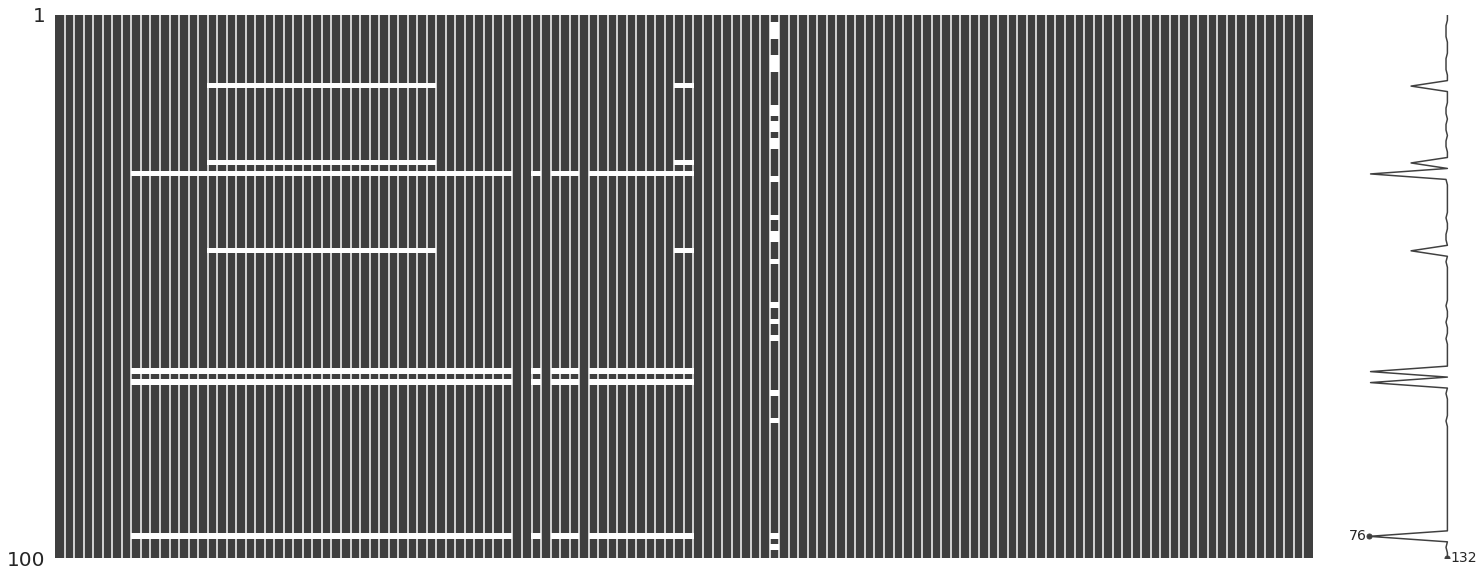

In [96]:
df3 = df2.copy()

for col in ['COD_EJEC_ORIGEN', 'DEP_PLAZO', 'CUADRANTE']:
    if col in df3.columns:
        del df3[col]

# pesos en cuentas, reemplazar NaN (n hay cuanta) con cero (pesos)
df3.fillna({'CHEQ_SIN_CV':0, 'CHEQ_CV':0, 'CTA_CTE':0, 'FONDOS_MUTUOS':0,
            'AHORRO':0, 'TCDN':0, 'TCDI':0}, inplace=True)

df3.fillna({'comuna':999, 'NPB30':0, 'MPB30':0, 'MPE3090':0, 'MA6M':0,
            'Cant_Op_12M_SICA':cantop12m_promedio, 'Ptje_SICA':ptje_promedio}, inplace=True)

missingno.matrix(df3[:100]);

## Reemplazar columnas de texto
Para casi todos los algoritmos necesitamos que todas las columnas contengan números. Hay distintas maneras de convertir texto a números, por ejemplo LabelEncoders, OneHotEncoders cuando tengamos un par de valores que son las clasificaciones. También es posible análizar texto y extraer palabras claves.

### Clasificaciones de texto
Tenemos algunas columnas con clasificaciones. Veamos contiene por ejemplo `Perfil_Riesgo`:

In [97]:
df3['Perfil_Riesgo'].unique()

array(['BUENO', 'EXCELENTE', 'REGULAR', 'MALO', nan], dtype=object)

Tenemos entonces cinco valores distintos, incluido `nan`. ¿Cómo son las otras columnas?

In [98]:
for col in df3.columns:
    if df3[col].dtype == np.object:
        valores = df3[col].unique()
        if len(valores) > 100:
            print('\n%s: más que 100 distintos valors' % (col))
        else:
            print('\n%s:' % (col), valores)


act_eco_des: más que 100 distintos valors

Nuevo_Antiguo_Prod: ['NUEVO' 'ANTIGUO' nan]

Comportamiento_SBFI: ['BUENO' 'EXCELENTE' 'REGULAR' 'MALO' nan
 'BUENO (CLIENTE SIN ACTIVIDAD SBIF EN LOS ÚLTIMOS 6 MESES)'
 'SIN COMPORTAMIENTO SF (REGULAR)']

Comportamiento_BEME: ['BUENO' 'EXCELENTE' 'REGULAR' nan 'MALO'
 'SIN COMPORTAMIENTO BEME (BUENO)' 'SIN COMPORTAMIENTO BEME (REGULAR)']

Perfil_Riesgo: ['BUENO' 'EXCELENTE' 'REGULAR' 'MALO' nan]

PERFIL: ['MI' nan]

OFICINA: más que 100 distintos valors

MODULO: ['Metrop. Norte' 'Metrop. Sur' 'Metrop. Centro' 'V Región Costa'
 'II Región' 'Metrop. Poniente' 'IV Región' 'Metrop. Oriente' 'I Región'
 'V Región Cordillera' 'VIII Región Costa' 'XIV Región de los Ríos'
 'IX Región Sur' 'VII Región' 'X Región de los Lagos' 'XI Región'
 'VI Región' 'Gestión Centralizada' 'IX Región Norte' 'III Región'
 'VIII Región Cordillera' 'XII Región' 'VIII Región Bio Bio Norte'
 'VIII Región Bio Bio Sur' 'XV Región' nan]

TIPO_CLIENTE: ['deudor comercial' 'no

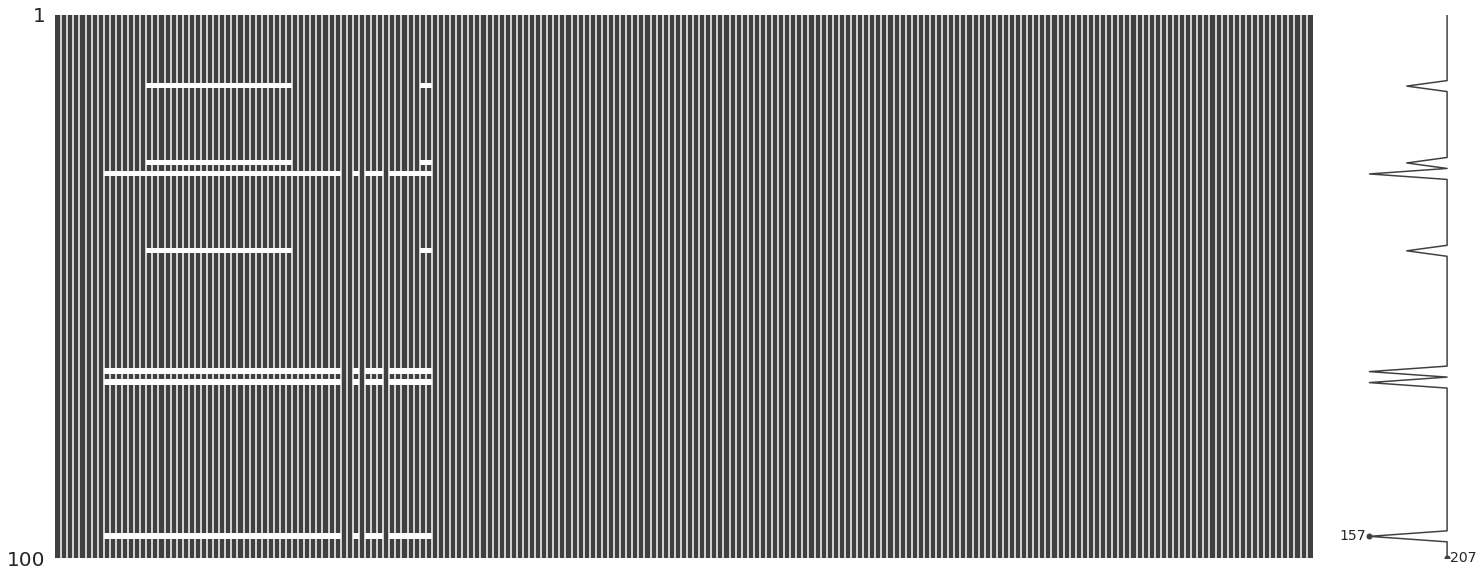

In [99]:
df4 = df3.copy()

# borrar columnas que no son categoricas o que tienen solo un valor distinto
for col in ['act_eco_des', 'PERFIL', 'OFICINA']:
    if col in df4.columns:
        del df4[col]

for col in ['TIPO_CLIENTE', 'Nuevo_Antiguo_Prod', 'Comportamiento_SBFI', 'Comportamiento_BEME',
            'Perfil_Riesgo', 'MODULO', 'Medidas_Restrictivas', 'FRECUENCIA_INGRESO', 'FORMALIDAD',
            'SCP_MTT_TIT_SEX', 'SCP_MIC_FOR', 'SCP_MIC_SGM', 'CHEQ']:
    encoded = pd.get_dummies(df4[col], prefix=col, dummy_na=True)
    df4 = pd.concat([df4, encoded], axis=1).drop(col, axis=1)

missingno.matrix(df4[:100]);

## Borrar filas con `nan`
Como vemos arriba, tenemos algunas filas con `nan`. Esas filas no nos sirve por tener pocos datos. Con `dropna()` podemos borrar las. Vemos que quedamos con más o menos dos tercero de los datos.

In [100]:
df5 = df4.copy()
df5 = df5.dropna()
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22018 entries, 0 to 32769
Columns: 207 entries, Ventas_IT to CHEQ_nan
dtypes: float64(73), int64(43), uint8(91)
memory usage: 21.6 MB


## Distribucion de los datos
Algunas columnas son mal distribuidos. La distribucion podemos graficar con histogrames:

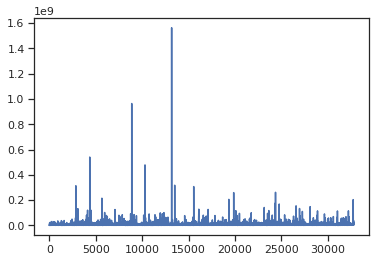

In [101]:
plt.plot(df5['Ventas_IT']);

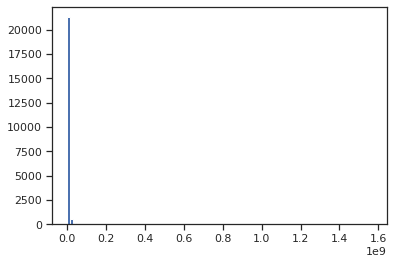

In [102]:
plt.hist(df5['Ventas_IT'], bins=100);

Significa que al menos la primera columna es mal distribuido. Casi todos los datos estan concentrados alrededor de cero, mientras hay algunos valores que son muy altos, cerca 1.6 x 10^9.

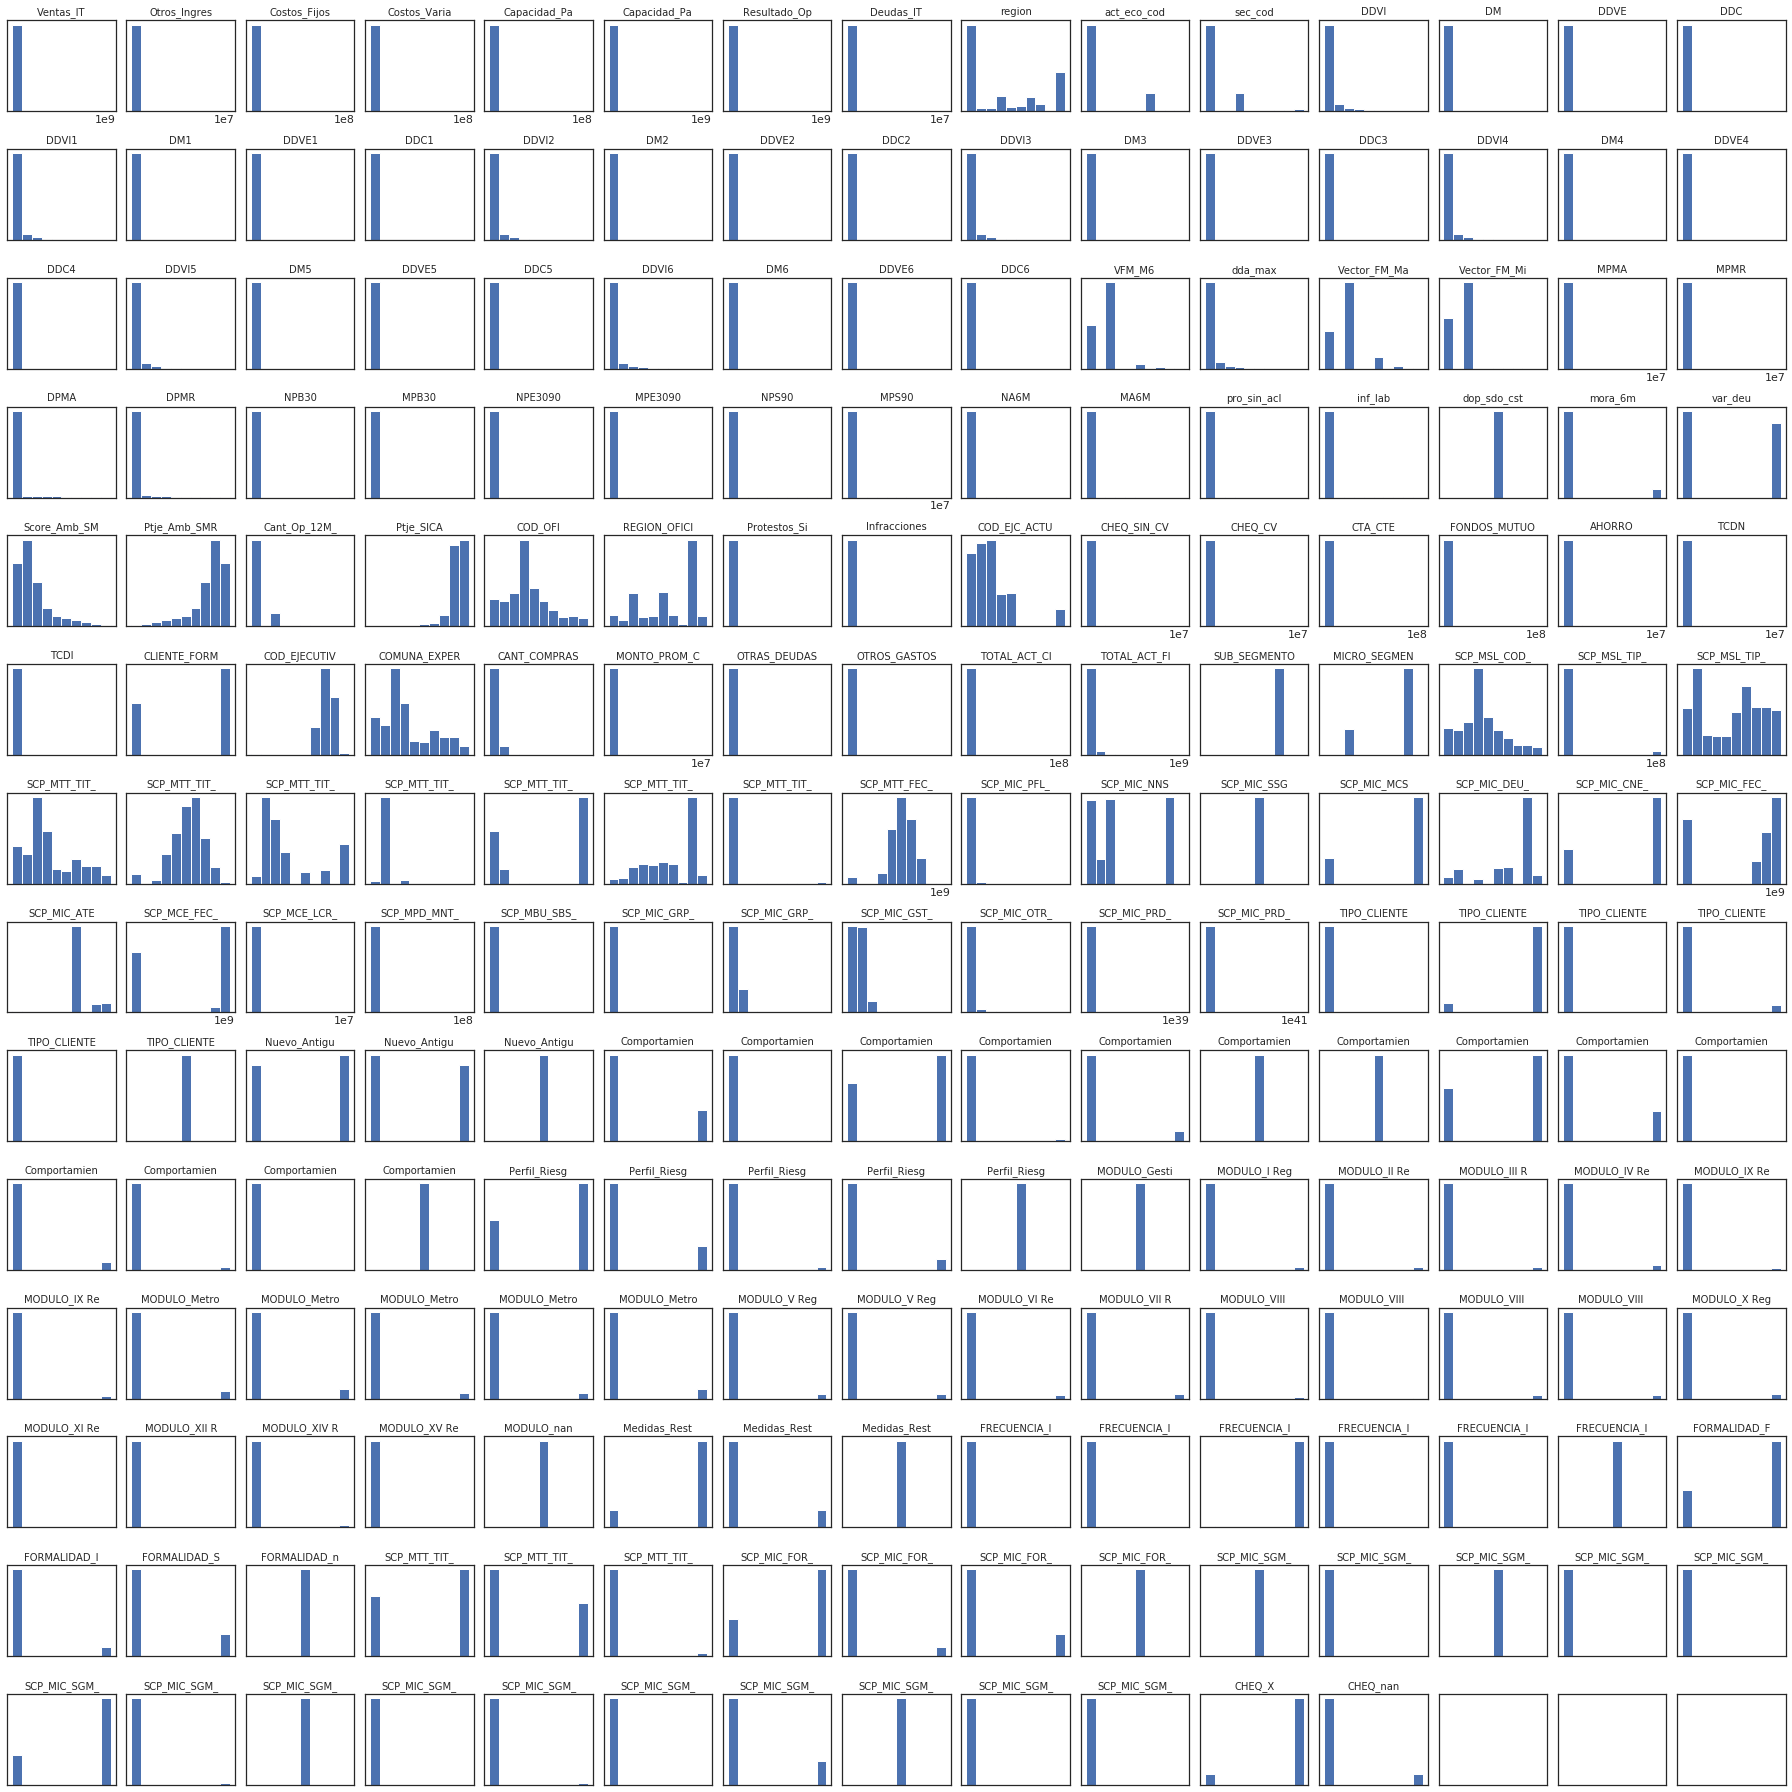

In [16]:
def plot_histograms(df):
    width = int(np.ceil(np.sqrt(len(df.columns))))
    height = int(np.ceil(len(df.columns) / width))
    fig, axes = plt.subplots(height, width, figsize=(25, 25), tight_layout=True)

    for j in range(height):
        for i in range(width):        
            ax = axes[j,i]
            col = j*width+i
            if col < len(df.columns):
                title = df5.columns[col]
                if len(title) > 12:
                    title = title[:12]
                ax.set_title(title, fontdict={'fontsize': 10.0})
                
                data = df.iloc[:, col]
                ax.hist(data)            
            ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

plot_histograms(df5)

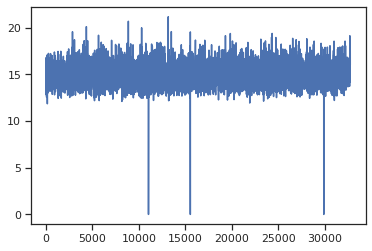

In [103]:
plt.plot(np.log(df5['Ventas_IT']+1));

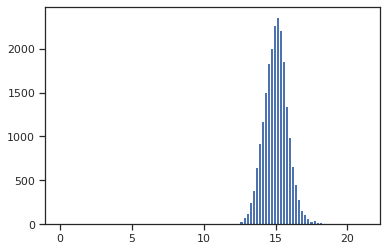

In [104]:
plt.hist(np.log(df5['Ventas_IT']+1), bins=100);

In [105]:
df6 = df5.copy()

log_columns = ['Ventas_IT','Otros_Ingresos_IT','Costos_Fijos_IT','Costos_Variables_IT',
               'Capacidad_Pago_Ajustada_IT','Capacidad_Pago_IT','Resultado_Operacional_IT','Deudas_IT',
               'DDVI','DM','DDVE','DDC','DDVI1','DM1','DDVE1','DDC1','DDVI2','DM2','DDVE2','DDC2','DDVI3',
               'DM3','DDVE3','DDC3','DDVI4','DM4','DDVE4','DDC4','DDVI5','DM5','DDVE5','DDC5','DDVI6','DM6',
               'DDVE6','DDC6','MPMA','MPMR','DPMA','DPMR','NPB30','MPB30','NPE3090','MPE3090','NPS90','MPS90',
               'NA6M','MA6M','pro_sin_acl','inf_lab','CHEQ_SIN_CV','CHEQ_CV','CTA_CTE','FONDOS_MUTUOS','AHORRO',
              'CANT_COMPRAS_MENSUALES','OTRAS_DEUDAS','OTROS_GASTOS_ME','TOTAL_ACT_CIRC','TOTAL_ACT_FIJO']

columns_min = df6.min()
df6[log_columns] = np.log(df6[log_columns] - columns_min[log_columns] + 1)

def invert_log(df):
    columns = df.columns[df.columns.isin(log_columns)]
    df[columns] = np.exp(df[columns]) + columns_min[columns] - 1
    return df

df6.head(10)

,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT,region,act_eco_cod,sec_cod,DDVI,DM,DDVE,DDC,DDVI1,DM1,DDVE1,DDC1,DDVI2,DM2,DDVE2,DDC2,DDVI3,DM3,DDVE3,DDC3,DDVI4,DM4,DDVE4,DDC4,DDVI5,DM5,DDVE5,DDC5,DDVI6,DM6,DDVE6,DDC6,VFM_M6,dda_max,Vector_FM_Max,Vector_FM_Min,MPMA,MPMR,DPMA,DPMR,NPB30,MPB30,NPE3090,MPE3090,NPS90,MPS90,NA6M,MA6M,pro_sin_acl,inf_lab,dop_sdo_cst,mora_6m,var_deu,Score_Amb_SMRT01,Ptje_Amb_SMRT01,Cant_Op_12M_SICA,Ptje_SICA,COD_OFI,REGION_OFICINA,Protestos_Sin_Aclarar,Infracciones_Laborales,COD_EJC_ACTUAL,CHEQ_SIN_CV,CHEQ_CV,CTA_CTE,FONDOS_MUTUOS,AHORRO,TCDN,TCDI,CLIENTE_FORMAL,COD_EJECUTIVO,COMUNA_EXPERIAN,CANT_COMPRAS_MENSUALES,MONTO_PROM_COMPRA,OTRAS_DEUDAS,OTROS_GASTOS_ME,TOTAL_ACT_CIRC,TOTAL_ACT_FIJO,SUB_SEGMENTO,MICRO_SEGMENTO,SCP_MSL_COD_SUC,SCP_MSL_TIP_CRD_SOL,SCP_MSL_TIP_MDU,SCP_MTT_TIT_COM,SCP_MTT_TIT_EDA,SCP_MTT_TIT_EST_CIV,SCP_MTT_TIT_NAC,SCP_MTT_TIT_RGM_CYG,SCP_MTT_TIT_RGN,SCP_MTT_TIT_TSC_CMR,SCP_MTT_FEC_NCT_CLI,SCP_MIC_PFL_PMA_NEG,SCP_MIC_NNS,SCP_MIC_SSG,SCP_MIC_MCS,SCP_MIC_DEU_PRO_VIV,SCP_MIC_CNE_INA,SCP_MIC_FEC_INA,SCP_MIC_ATE,SCP_MCE_FEC_ULT_CRD,SCP_MCE_LCR_DIS,SCP_MPD_MNT_SOL,SCP_MBU_SBS_HBT_ASG,SCP_MIC_GRP_FAM_ADL,SCP_MIC_GRP_FAM_NNO,SCP_MIC_GST_FAM_SME,SCP_MIC_OTR_GST_VIV,SCP_MIC_PRD_COS_MOB,SCP_MIC_PRD_COS_MPM,TIPO_CLIENTE_castigado,TIPO_CLIENTE_deudor comercial,TIPO_CLIENTE_deudor no comercial,TIPO_CLIENTE_no deudor,TIPO_CLIENTE_sin producto,TIPO_CLIENTE_nan,Nuevo_Antiguo_Prod_ANTIGUO,Nuevo_Antiguo_Prod_NUEVO,Nuevo_Antiguo_Prod_nan,Comportamiento_SBFI_BUENO,Comportamiento_SBFI_BUENO (CLIENTE SIN ACTIVIDAD SBIF EN LOS ÚLTIMOS 6 MESES),Comportamiento_SBFI_EXCELENTE,Comportamiento_SBFI_MALO,Comportamiento_SBFI_REGULAR,Comportamiento_SBFI_SIN COMPORTAMIENTO SF (REGULAR),Comportamiento_SBFI_nan,Comportamiento_BEME_BUENO,Comportamiento_BEME_EXCELENTE,Comportamiento_BEME_MALO,Comportamiento_BEME_REGULAR,Comportamiento_BEME_SIN COMPORTAMIENTO BEME (BUENO),Comportamiento_BEME_SIN COMPORTAMIENTO BEME (REGULAR),Comportamiento_BEME_nan,Perfil_Riesgo_BUENO,Perfil_Riesgo_EXCELENTE,Perfil_Riesgo_MALO,Perfil_Riesgo_REGULAR,Perfil_Riesgo_nan,MODULO_Gestión Centralizada,MODULO_I Región,MODULO_II Región,MODULO_III Región,MODULO_IV Región,MODULO_IX Región Norte,MODULO_IX Región Sur,MODULO_Metrop. Centro,MODULO_Metrop. Norte,MODULO_Metrop. Oriente,MODULO_Metrop. Poniente,MODULO_Metrop. Sur,MODULO_V Región Cordillera,MODULO_V Región Costa,MODULO_VI Región,MODULO_VII Región,MODULO_VIII Región Bio Bio Norte,MODULO_VIII Región Bio Bio Sur,MODULO_VIII Región Cordillera,MODULO_VIII Región Costa,MODULO_X Región de los Lagos,MODULO_XI Región,MODULO_XII Región,MODULO_XIV Región de los Ríos,MODULO_XV Región,MODULO_nan,Medidas_Restrictivas_NO,Medidas_Restrictivas_SI,Medidas_Restrictivas_nan,FRECUENCIA_INGRESO_A,FRECUENCIA_INGRESO_B,FRECUENCIA_INGRESO_M,FRECUENCIA_INGRESO_S,FRECUENCIA_INGRESO_T,FRECUENCIA_INGRESO_nan,FORMALIDAD_FO,FORMALIDAD_IN,FORMALIDAD_SF,FORMALIDAD_nan,SCP_MTT_TIT_SEX_F,SCP_MTT_TIT_SEX_M,SCP_MTT_TIT_SEX_nan,SCP_MIC_FOR_FO,SCP_MIC_FOR_IN,SCP_MIC_FOR_SF,SCP_MIC_FOR_nan,SCP_MIC_SGM_ECONC,SCP_MIC_SGM_ECONT,SCP_MIC_SGM_EGEMP,SCP_MIC_SGM_EMEDM,SCP_MIC_SGM_ISFL,SCP_MIC_SGM_MMIC,SCP_MIC_SGM_MMICA,SCP_MIC_SGM_MMSIN,SCP_MIC_SGM_MPEQ,SCP_MIC_SGM_MSOM,SCP_MIC_SGM_MSOP,SCP_MIC_SGM_PERSO,SCP_MIC_SGM_SINSE,SCP_MIC_SGM_SNCLA,SCP_MIC_SGM_nan,CHEQ_X,CHEQ_nan
0,13.890774,11.350418,10.558439,13.304687,13.404473,13.915298,14.021805,0.000000,5.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.078022,921.97797,0.000000,934.268799,331.0,13.0,0.0,0.0,6062.0,3.465736,0.0,12.214403,0.0,11.320941,0.0,0.0,0,6817,81,1.609438,150000,0.000000,0.0,13.217675,17.223353,106,1943,331,101,5,81,80,4,1,9,13,1,1.135728e+09,600,9088,106,1943,6,0,0.000000e+00

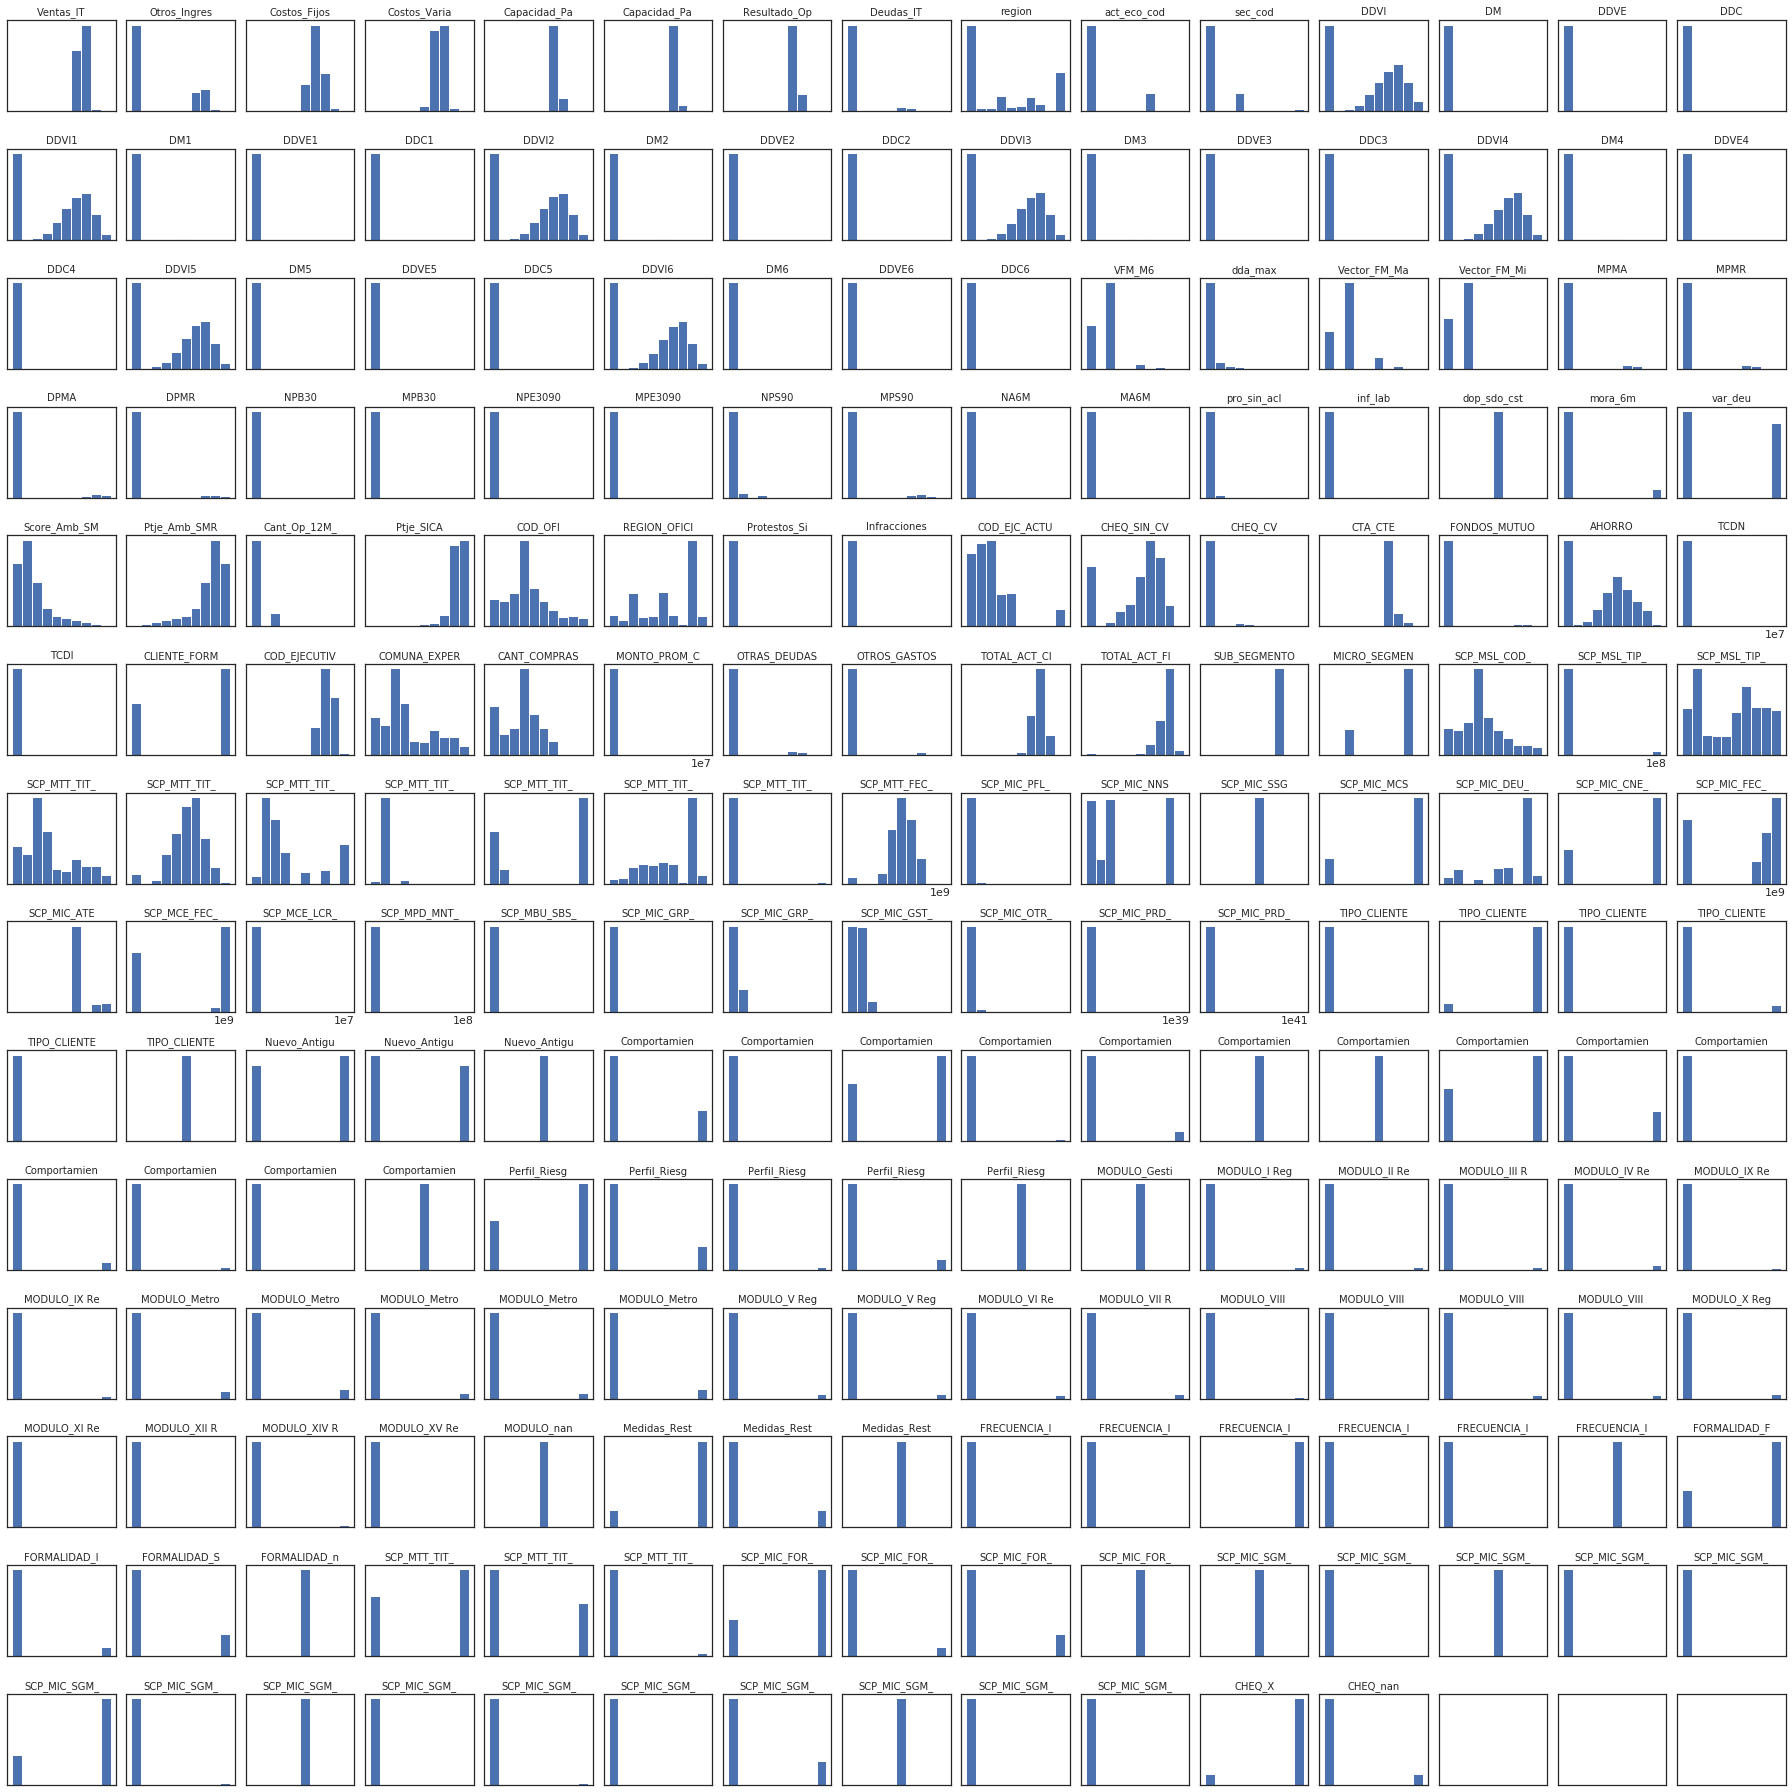

In [20]:
plot_histograms(df6)

## Normalización de los datos
Para ingresar a un modelo red neuronal, la normalización de los datos entrados ayuda la red para entrenar más rápido. Para la normalización, vamos usar `sklearn`. La fórmula para normalizar es dado por:

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Eso significa que tenemos que sacar columnas en que $x_{max}$ y $x_{min}$ son iguales para evitar dividir por cero.

In [106]:
df7 = df6.copy()

for col in df7.columns:
    if df7[col].max()-df7[col].min() == 0:
        print('Columna %s tiene valores entre %f--%f' % (col, df7[col].min(), df7[col].max()))
        del df7[col]

Columna dop_sdo_cst tiene valores entre 0.000000--0.000000
Columna SCP_MIC_SSG tiene valores entre 106.000000--106.000000
Columna TIPO_CLIENTE_nan tiene valores entre 0.000000--0.000000
Columna Nuevo_Antiguo_Prod_nan tiene valores entre 0.000000--0.000000
Columna Comportamiento_SBFI_SIN COMPORTAMIENTO SF (REGULAR) tiene valores entre 0.000000--0.000000
Columna Comportamiento_SBFI_nan tiene valores entre 0.000000--0.000000
Columna Comportamiento_BEME_nan tiene valores entre 0.000000--0.000000
Columna Perfil_Riesgo_nan tiene valores entre 0.000000--0.000000
Columna MODULO_Gestión Centralizada tiene valores entre 0.000000--0.000000
Columna MODULO_nan tiene valores entre 0.000000--0.000000
Columna Medidas_Restrictivas_nan tiene valores entre 0.000000--0.000000
Columna FRECUENCIA_INGRESO_nan tiene valores entre 0.000000--0.000000
Columna FORMALIDAD_nan tiene valores entre 0.000000--0.000000
Columna SCP_MIC_FOR_nan tiene valores entre 0.000000--0.000000
Columna SCP_MIC_SGM_ECONC tiene valore

In [107]:
df8 = df7.copy()

columns_min = df8.min()
columns_max = df8.max()
scale_columns = df8.columns
df8[scale_columns] = (df8[scale_columns] - columns_min[scale_columns])/(columns_max[scale_columns]-columns_min[scale_columns])

def invert_scale(df):
    columns = df.columns[df.columns.isin(scale_columns)]
    df[columns] = df[columns] * (columns_max[columns] - columns_min[columns]) + columns_min[columns]
    return df

df8.head(10)

,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT,region,act_eco_cod,sec_cod,DDVI,DM,DDVE,DDC,DDVI1,DM1,DDVE1,DDC1,DDVI2,DM2,DDVE2,DDC2,DDVI3,DM3,DDVE3,DDC3,DDVI4,DM4,DDVE4,DDC4,DDVI5,DM5,DDVE5,DDC5,DDVI6,DM6,DDVE6,DDC6,VFM_M6,dda_max,Vector_FM_Max,Vector_FM_Min,MPMA,MPMR,DPMA,DPMR,NPB30,MPB30,NPE3090,MPE3090,NPS90,MPS90,NA6M,MA6M,pro_sin_acl,inf_lab,mora_6m,var_deu,Score_Amb_SMRT01,Ptje_Amb_SMRT01,Cant_Op_12M_SICA,Ptje_SICA,COD_OFI,REGION_OFICINA,Protestos_Sin_Aclarar,Infracciones_Laborales,COD_EJC_ACTUAL,CHEQ_SIN_CV,CHEQ_CV,CTA_CTE,FONDOS_MUTUOS,AHORRO,TCDN,TCDI,CLIENTE_FORMAL,COD_EJECUTIVO,COMUNA_EXPERIAN,CANT_COMPRAS_MENSUALES,MONTO_PROM_COMPRA,OTRAS_DEUDAS,OTROS_GASTOS_ME,TOTAL_ACT_CIRC,TOTAL_ACT_FIJO,SUB_SEGMENTO,MICRO_SEGMENTO,SCP_MSL_COD_SUC,SCP_MSL_TIP_CRD_SOL,SCP_MSL_TIP_MDU,SCP_MTT_TIT_COM,SCP_MTT_TIT_EDA,SCP_MTT_TIT_EST_CIV,SCP_MTT_TIT_NAC,SCP_MTT_TIT_RGM_CYG,SCP_MTT_TIT_RGN,SCP_MTT_TIT_TSC_CMR,SCP_MTT_FEC_NCT_CLI,SCP_MIC_PFL_PMA_NEG,SCP_MIC_NNS,SCP_MIC_MCS,SCP_MIC_DEU_PRO_VIV,SCP_MIC_CNE_INA,SCP_MIC_FEC_INA,SCP_MIC_ATE,SCP_MCE_FEC_ULT_CRD,SCP_MCE_LCR_DIS,SCP_MPD_MNT_SOL,SCP_MBU_SBS_HBT_ASG,SCP_MIC_GRP_FAM_ADL,SCP_MIC_GRP_FAM_NNO,SCP_MIC_GST_FAM_SME,SCP_MIC_OTR_GST_VIV,SCP_MIC_PRD_COS_MOB,SCP_MIC_PRD_COS_MPM,TIPO_CLIENTE_castigado,TIPO_CLIENTE_deudor comercial,TIPO_CLIENTE_deudor no comercial,TIPO_CLIENTE_no deudor,TIPO_CLIENTE_sin producto,Nuevo_Antiguo_Prod_ANTIGUO,Nuevo_Antiguo_Prod_NUEVO,Comportamiento_SBFI_BUENO,Comportamiento_SBFI_BUENO (CLIENTE SIN ACTIVIDAD SBIF EN LOS ÚLTIMOS 6 MESES),Comportamiento_SBFI_EXCELENTE,Comportamiento_SBFI_MALO,Comportamiento_SBFI_REGULAR,Comportamiento_BEME_BUENO,Comportamiento_BEME_EXCELENTE,Comportamiento_BEME_MALO,Comportamiento_BEME_REGULAR,Comportamiento_BEME_SIN COMPORTAMIENTO BEME (BUENO),Comportamiento_BEME_SIN COMPORTAMIENTO BEME (REGULAR),Perfil_Riesgo_BUENO,Perfil_Riesgo_EXCELENTE,Perfil_Riesgo_MALO,Perfil_Riesgo_REGULAR,MODULO_I Región,MODULO_II Región,MODULO_III Región,MODULO_IV Región,MODULO_IX Región Norte,MODULO_IX Región Sur,MODULO_Metrop. Centro,MODULO_Metrop. Norte,MODULO_Metrop. Oriente,MODULO_Metrop. Poniente,MODULO_Metrop. Sur,MODULO_V Región Cordillera,MODULO_V Región Costa,MODULO_VI Región,MODULO_VII Región,MODULO_VIII Región Bio Bio Norte,MODULO_VIII Región Bio Bio Sur,MODULO_VIII Región Cordillera,MODULO_VIII Región Costa,MODULO_X Región de los Lagos,MODULO_XI Región,MODULO_XII Región,MODULO_XIV Región de los Ríos,MODULO_XV Región,Medidas_Restrictivas_NO,Medidas_Restrictivas_SI,FRECUENCIA_INGRESO_A,FRECUENCIA_INGRESO_B,FRECUENCIA_INGRESO_M,FRECUENCIA_INGRESO_S,FRECUENCIA_INGRESO_T,FORMALIDAD_FO,FORMALIDAD_IN,FORMALIDAD_SF,SCP_MTT_TIT_SEX_F,SCP_MTT_TIT_SEX_M,SCP_MTT_TIT_SEX_nan,SCP_MIC_FOR_FO,SCP_MIC_FOR_IN,SCP_MIC_FOR_SF,SCP_MIC_SGM_ECONT,SCP_MIC_SGM_EMEDM,SCP_MIC_SGM_ISFL,SCP_MIC_SGM_MMIC,SCP_MIC_SGM_MMICA,SCP_MIC_SGM_MPEQ,SCP_MIC_SGM_MSOM,SCP_MIC_SGM_MSOP,SCP_MIC_SGM_PERSO,SCP_MIC_SGM_SNCLA,SCP_MIC_SGM_nan,CHEQ_X,CHEQ_nan
0,0.656145,0.662339,0.568466,0.646076,0.661869,0.657359,0.662385,0.000000,0.384615,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.050045,0.949955,0.000000,0.905609,0.358696,0.857143,0.000000,0.0,0.017641,0.193819,0.0,0.624725,0.0,0.624282,0.040258,0.0,0.0,0.765525,0.233429,0.331173,0.003413,0.000000,0.0,0.644682,0.827307,0.757143,0.246636,0.358696,9.609154e-07,0.130435,0.233429,0.930233,0.500,0.166667,1.0,0.866667,0.0,0.307788,0.138889,0.260377,0.001180,0.833333,0.0,0.000000,0.852174,0.902625,0.000000,0.0024,0.0,0.0250,0.05,0.080,0.0,0.0,6.250000e-09,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,

## Separar entre entradas y salidas, y entre datos para entrenar y para testear

In [108]:
df = df8

def separate_data(output_features, test_size=0.30):
    single_output_feature = not isinstance(output_features, list)
    if single_output_feature:
        output_features = [output_features]
    
    input_features = df.columns[~df.columns.isin(output_features)]
    X = df[input_features]
    y = df[output_features]
    if single_output_feature:
        y = y.squeeze()
        
    if test_size > 0.0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    else:
        X_train = X
        y_train = y
        X_test = None
        y_test = None
    return X_train, X_test, y_train, y_test

## Medida de error

In [109]:
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def print_error(y_train, y_test, y_train_pred, y_test_pred):
    y_train = y_train.values
    y_test = y_test.values
    mae_train = np.mean(abs(y_train_pred - y_train))
    mae_test = np.mean(abs(y_test_pred - y_test))
    print('MAE:  train=%g  test=%g' % (mae_train, mae_test))
    
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    print('MAPE:  train=%.2f%%  test=%.2f%%' % (mape_train, mape_test))

## Similitud de los datos

In [110]:
output_features = ['Ventas_IT', 'Costos_Fijos_IT', 'Costos_Variables_IT']
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.5)

for col in output_features:
    print('Mean±Std of %s:\n   train=%.6f±%.6f\n    test=%.6f±%.6f\n' % (col,
          np.mean(y_train[col]), np.std(y_train[col]), np.mean(y_test[col]), np.std(y_test[col])))

Mean±Std of Ventas_IT:
   train=0.708885±0.040763
    test=0.707604±0.041903

Mean±Std of Costos_Fijos_IT:
   train=0.660625±0.066969
    test=0.658924±0.068795

Mean±Std of Costos_Variables_IT:
   train=0.695206±0.069125
    test=0.694140±0.070131



In [111]:
output_features = ['Ventas_IT', 'Costos_Fijos_IT', 'Costos_Variables_IT']
X, _, y, _ = separate_data(output_features, test_size=0.0)

X_norm = np.linalg.norm(X, axis=1).reshape(-1, 1)
y_norm = np.linalg.norm(y, axis=1).reshape(-1, 1)

cos_sim = metrics.pairwise.cosine_similarity(X_norm, y_norm)

print('Cosine similarity:  %g±%g\n' % (np.mean(cos_sim), np.std(cos_sim)))

Cosine similarity:  0.999864±0.0116719



# Red Neuronal

In [136]:
class Net(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super(Net, self).__init__()
        print("Input dimension:", n_in)
        print("Output dimension:", n_out)
        self.fc1 = torch.nn.Linear(n_in, 360)
        self.fc2 = torch.nn.Linear(360, 720)
        self.fc3 = torch.nn.Linear(720, 1440)
        self.fc4 = torch.nn.Linear(1440, 1440)
        self.fc5 = torch.nn.Linear(1440, 1440)
        self.fc6 = torch.nn.Linear(1440, 720)
        self.fc7 = torch.nn.Linear(720, 180)
        self.fc8 = torch.nn.Linear(180, 90)
        self.fc9 = torch.nn.Linear(90, 45)
        self.fc10 = torch.nn.Linear(45,n_out)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        x = self.fc10(x)
        return x

## Entrenar

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print('Device:', device)

#output_features = ['Ventas_IT']
output_features = ['Ventas_IT','Otros_Ingresos_IT','Costos_Fijos_IT','Costos_Variables_IT',
                   'Capacidad_Pago_Ajustada_IT','Capacidad_Pago_IT','Resultado_Operacional_IT','Deudas_IT']
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.3)

n_in = len(X_train.columns)
n_out = len(y_train.columns)
modelo = Net(n_in, n_out).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss().to(device)

X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)

dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=500)

losses = []
losses_test = []
for epoch in range(20000):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        xs, ys = data
        
        modelo.zero_grad()

        outputs = modelo(xs)
        
        loss = criterion(outputs, ys)
        loss.backward()        
        optimizer.step()
        
        running_loss += loss.item()
    
    y_test_pred = modelo(X_test_tensor).cpu().detach().numpy()
    loss_test = np.mean(abs(y_test_pred - y_test.values))
    
    if (epoch+1)%1000 == 0:
        print('[%4d] loss_train: %.8f  loss_test: %.8f' % (epoch+1, running_loss, loss_test))
    losses.append(running_loss)    
    losses_test.append(loss_test)

print('Finished Training')

Device: cuda:0
Input dimension: 181
Output dimension: 8
[1000] loss_train: 0.00283487  loss_test: 0.05499678
[2000] loss_train: 0.00156173  loss_test: 0.05382891
[3000] loss_train: 0.00238878  loss_test: 0.05184842
[4000] loss_train: 0.00040398  loss_test: 0.05232072
[5000] loss_train: 0.00204156  loss_test: 0.05293596


In [ ]:
for epoch in range(750):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        xs, ys = data
        
        modelo.zero_grad()

        outputs = modelo(xs)
        
        loss = criterion(outputs, ys)
        loss.backward()        
        optimizer.step()
        
        running_loss += loss.item()
    
    y_test_pred = modelo(X_test_tensor).cpu().detach().numpy()
    loss_test = np.mean(abs(y_test_pred - y_test.values))
    
    if (epoch+1)%10 == 0:
        print('[%4d] loss_train: %.8f  loss_test: %.8f' % (epoch+1, running_loss, loss_test))
    losses.append(running_loss)    
    losses_test.append(loss_test)

print('Finished Training')

In [116]:
#torch.save(modelo.state_dict(), 'red_500000.pth')

In [124]:
#modelo = Net(n_in, n_out).to(device)
#modelo.load_state_dict(torch.load('red_500000.pth'))
#modelo.eval();

Input dimension: 181
Output dimension: 8


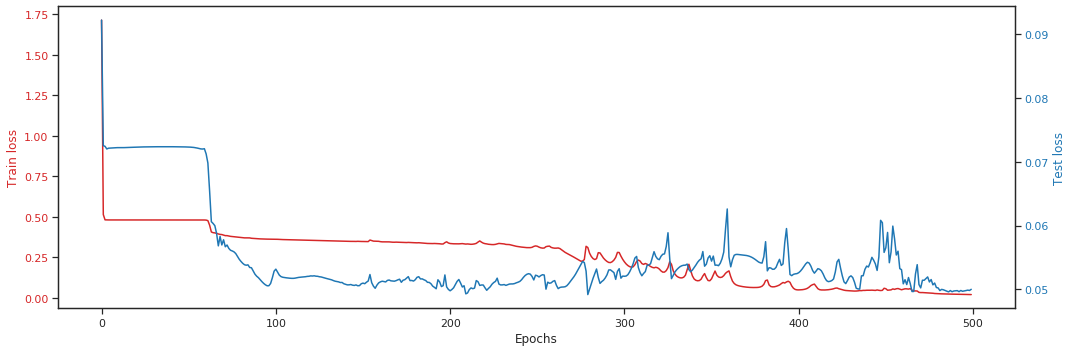

In [129]:
fig, ax1 = plt.subplots(figsize=(15,5))

color = 'tab:red'
ax1.set_ylabel('Train loss', color=color)
ax1.plot(np.log1p(losses), color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('Test loss', color=color)
ax2.plot(np.log1p(losses_test), color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlabel('Epochs')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [130]:
y_train_pred = modelo(X_train_tensor).cpu().detach().numpy()
y_test_pred = modelo(X_test_tensor).cpu().detach().numpy()
print_error(y_train, y_test, y_train_pred, y_test_pred)

MAE:  train=0.0154573  test=0.0512732
MAPE:  train=2.80%  test=7.84%


# Regresión lineal

In [ ]:
from sklearn.linear_model import Ridge

output_features = ['Ventas_IT','Otros_Ingresos_IT','Costos_Fijos_IT','Costos_Variables_IT',
                   'Capacidad_Pago_Ajustada_IT','Capacidad_Pago_IT','Resultado_Operacional_IT','Deudas_IT']
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.3)

modelo = Ridge(alpha=1.0)
modelo.fit(X_train, y_train)

y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)
print_error(y_train, y_test, y_train_pred, y_test_pred)

In [ ]:
from sklearn.linear_model import Lasso

output_features = ['Ventas_IT','Otros_Ingresos_IT','Costos_Fijos_IT','Costos_Variables_IT',
                   'Capacidad_Pago_Ajustada_IT','Capacidad_Pago_IT','Resultado_Operacional_IT','Deudas_IT']
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.3)

modelo = Lasso(alpha=1.0)
modelo.fit(X_train, y_train)

y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)
print_error(y_train, y_test, y_train_pred, y_test_pred)

# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

output_features = ['Ventas_IT','Otros_Ingresos_IT','Costos_Fijos_IT','Costos_Variables_IT',
                   'Capacidad_Pago_Ajustada_IT','Capacidad_Pago_IT','Resultado_Operacional_IT','Deudas_IT']
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.3)

modelo = RandomForestRegressor(max_depth=2, random_state=42, n_estimators=100)
modelo.fit(X_train, y_train)

y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)
print_error(y_train, y_test, y_train_pred, y_test_pred)

# Boost

In [33]:
from sklearn.ensemble import AdaBoostRegressor

output_features = 'Ventas_IT'
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.3)

modelo = AdaBoostRegressor(random_state=42, n_estimators=10)
modelo.fit(X_train, y_train)

y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)
print_error(y_train, y_test, y_train_pred, y_test_pred)

MAE:  train=0.00734774  test=0.00743314
MAPE:  train=1.05%  test=1.06%


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

output_features = 'Ventas_IT'
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.3)

modelo = GradientBoostingRegressor(random_state=42, n_estimators=10)
modelo.fit(X_train, y_train)

y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)
print_error(y_train, y_test, y_train_pred, y_test_pred)

# XGBoost
Corre `pip install xgboost`

In [ ]:
from xgboost import XGBRegressor

output_features = 'Ventas_IT'
X_train, X_test, y_train, y_test = separate_data(output_features, test_size=0.3)

modelo = XGBRegressor(random_state=42, n_estimators=10)
modelo.fit(X_train, y_train)

y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)
print_error(y_train, y_test, y_train_pred, y_test_pred)

# Invertir transformaciones y guardar los resultados
Según las funciones definidas antes, tomamos las predicciones y invertimos las transformaciones aplicadas anteriormente a los datos. En este caso, tenemos que invertir primero la normalización (que fue la última transformación) y después la transformación logarítmica.

In [131]:
if isinstance(y_train, pd.Series):
    df_train_pred = pd.DataFrame(y_train_pred.copy(), index=y_train.index, columns=[output_features])
    df_test_pred = pd.DataFrame(y_test_pred.copy(), index=y_test.index, columns=[output_features])
else:
    df_train_pred = pd.DataFrame(y_train_pred.copy(), index=y_train.index, columns=y_train.columns)
    df_test_pred = pd.DataFrame(y_test_pred.copy(), index=y_test.index, columns=y_test.columns)

df_pred = df_train_pred.append(df_test_pred)
df_pred = invert_scale(df_pred)
df_pred = invert_log(df_pred)

df_pred

,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT
13794,3.149213e+06,290636.913522,132808.073217,1.838994e+06,8.718456e+05,1.404789e+06,1.708979e+06,-0.001942
16818,4.253237e+06,389981.131976,549297.972793,1.994037e+06,1.229387e+06,1.825095e+06,2.248383e+06,-0.047084
17480,3.263515e+06,622987.396488,128016.174927,1.814353e+06,9.759605e+05,1.617917e+06,1.826637e+06,0.256966
31706,1.520939e+06,0.122011,58213.824986,6.659702e+05,6.046467e+05,1.115583e+06,1.359489e+06,-0.049497
29187,2.376693e+06,-0.081271,113696.790025,1.334259e+06,7.327473e+05,1.269570e+06,1.720546e+06,0.018814
...,...,...,...,...,...,...,...,...
28833,7.869442e+05,191.545925,29756.265171,1.729769e+05,7.017929e+05,1.510461e+06,8.239678e+05,-0.325654
1354,3.445122e+06,329381.799061,150656.004311,2.969301e+06,8.959592e+05,1.394029e+06,1.804003e+06,0.005959
23426,2.041859e+06,328613.921404,95206.460068,1.872659e+06,7.835016e+05,1.120187e+06,1.473381e+06,0.038189
16489,3.677353e+06,52021.099991,211326.413994,3.463594e+06,9.052074e+05,1.261729e+06,1.962934e+06,0.013765


In [132]:
df_out = df5.copy()
if not isinstance(output_features, list):
    output_features = [output_features]

for col in output_features:    
    mask = df_out[col] > 0.0
    mae = abs(df_out[col]-df_pred[col])
    mape = (abs(df_out[col][mask]-df_pred[col][mask])/df_out[col][mask]) * 100
    
    df_out[col + '_true'] = df_out[col].astype(np.float64)
    df_out[col + '_pred'] = df_pred[col]
    df_out[col + '_mae'] = mae
    df_out[col + '_mape'] = mape
    
    print('%30s:  mae=%12g±%12g  mape=%8g%%±%8g%%' % (col, mae.mean(), mae.std(), mape.mean(), mape.std()))

df_out.to_csv('ventas_costos_prediccion.csv', index=False)
#df_out.to_excel('ventas_costos_prediccion.xlsx', index=False)

                     Ventas_IT:  mae= 2.06237e+06± 1.40321e+07  mape= 40.8678%± 48.4261%
             Otros_Ingresos_IT:  mae=       75665±      364078  mape= 26707.2%±1.24163e+06%
               Costos_Fijos_IT:  mae=      298212± 1.15852e+06  mape= 1005.55%±  136084%
           Costos_Variables_IT:  mae= 1.47387e+06± 7.94346e+06  mape=  243.54%± 12474.7%
    Capacidad_Pago_Ajustada_IT:  mae=      626634± 4.29783e+06  mape= 231.946%± 779.014%
             Capacidad_Pago_IT:  mae= 1.05387e+06±  1.0597e+07  mape= 262.891%± 787.228%
      Resultado_Operacional_IT:  mae= 1.05697e+06± 1.06509e+07  mape= 122.696%± 140.548%
                     Deudas_IT:  mae=     11261.4±      506068  mape= 87.6489%± 204.609%


# Visualizar resultados
Scatter plots entre verdad y predicción.

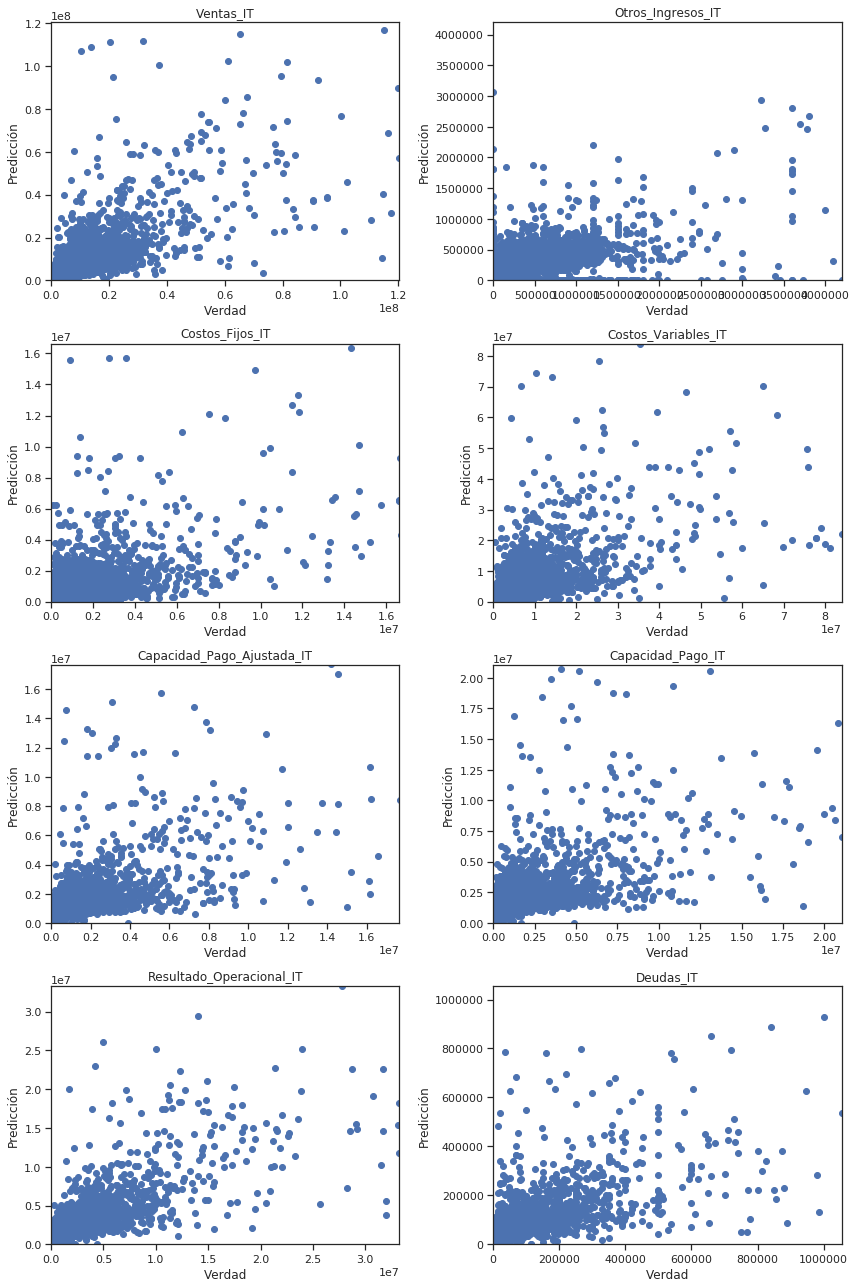

In [133]:
fig, axes = plt.subplots(int(np.ceil(len(output_features)/2)), 2, figsize=(12, 18), tight_layout=True)
for i, col in enumerate(output_features):
    j = int(i/2)
    i = i%2
    axes[j,i].set_title(col)
    axes[j,i].scatter(df_out[col + '_true'], df_out[col + '_pred'])
    lim = np.percentile(df_out[col + '_true'], 99.9)
    axes[j,i].set_xlim(0, lim)
    axes[j,i].set_ylim(0, lim)
    axes[j,i].set_xlabel('Verdad')
    axes[j,i].set_ylabel('Predicción')

$R^2$ valores

In [134]:
for col in output_features:
    r2 = metrics.r2_score(df_out[col + '_true'], df_out[col + '_pred'])
    print("%30s:  R2 = %f" % (col, r2))

                     Ventas_IT:  R2 = 0.195984
             Otros_Ingresos_IT:  R2 = 0.247456
               Costos_Fijos_IT:  R2 = 0.347213
           Costos_Variables_IT:  R2 = 0.251050
    Capacidad_Pago_Ajustada_IT:  R2 = 0.022920
             Capacidad_Pago_IT:  R2 = 0.004217
      Resultado_Operacional_IT:  R2 = 0.020647
                     Deudas_IT:  R2 = 0.115132
